In [1]:
import os
import random
import functools
from functools import partial
import PIL

import numpy as np 
import pandas as pd

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import timm

from transformers import AutoTokenizer
from transformers import DistilBertModel

np.random.seed(1337)

In [2]:
df = pd.read_csv('data/train.csv')

In [3]:
# train val split
labels = np.random.permutation(df['label_group'].unique())

train_perc = 0.7
train_idx = int(train_perc * len(labels))

train_labels = labels[:train_idx]
val_labels = labels[train_idx:]


In [4]:
# weights: https://drive.google.com/file/d/1Os090zP4h4500a91wJ-RMJLMJ8vnOhme/view?usp=sharing
#
# distill_bert_resnet18_emb_size_512_30ep.pth

embs = pd.read_csv('train_embs.csv', index_col = 'Unnamed: 0')

In [5]:
embs['label'] = df['label_group']

In [6]:
tr = embs[embs['label'].isin(train_labels)]
xtr = tr.iloc[:,:-1]
ytr = tr.iloc[:,-1]

val = embs[embs['label'].isin(val_labels)]
xval = val.iloc[:,:-1]
yval = val.iloc[:,-1]

In [7]:
dists = [np.linalg.norm(xtr - xtr.iloc[i], axis = 1) for i in tqdm(range(len(xtr)))]
dists = np.array(dists)

  0%|          | 0/23954 [00:00<?, ?it/s]

In [8]:
def actuals(labels, index):
    return (labels == labels.iloc[index]).astype(int)

In [9]:
all_actuals = [actuals(ytr,i) for i in tqdm(range(len(ytr)))]
all_actuals = np.array(all_actuals)

  0%|          | 0/23954 [00:00<?, ?it/s]

In [10]:
from sklearn.metrics import f1_score as f1

In [11]:
def get_score(distances, actuals, threshold):
    scores = []
    for i in tqdm(range(len(distances))):
        scores.append(f1(actuals[i], (distances[i] <= threshold).astype(int)))
    return np.mean(scores)

In [12]:
scores_1 = {t : get_score(dists, all_actuals, t) for t in [1, 5, 7]}

  0%|          | 0/23954 [00:00<?, ?it/s]

  0%|          | 0/23954 [00:00<?, ?it/s]

  0%|          | 0/23954 [00:00<?, ?it/s]

In [13]:
scores_1

{1: 0.4645626509612341, 5: 0.5691639528781764, 7: 0.6893552138484118}

In [14]:
scores_2 = {t : get_score(dists, all_actuals, t) for t in [3, 4, 6]}

  0%|          | 0/23954 [00:00<?, ?it/s]

  0%|          | 0/23954 [00:00<?, ?it/s]

  0%|          | 0/23954 [00:00<?, ?it/s]

In [15]:
scores_2

{3: 0.4931685046792633, 4: 0.5248488149750596, 6: 0.6257118415770332}

In [16]:
scores_3 = {t : get_score(dists, all_actuals, t) for t in [8, 9]}

  0%|          | 0/23954 [00:00<?, ?it/s]

  0%|          | 0/23954 [00:00<?, ?it/s]

In [17]:
scores_3

{8: 0.7307334785826578, 9: 0.6930443535350583}

In [18]:
scores_4 = {t : get_score(dists, all_actuals, t) for t in [7.5, 8.5]}

  0%|          | 0/23954 [00:00<?, ?it/s]

  0%|          | 0/23954 [00:00<?, ?it/s]

In [19]:
scores_4

{7.5: 0.7153463761143943, 8.5: 0.7253245822738796}

In [23]:
scores_5 = {t : get_score(dists, all_actuals, t) for t in [7.75, 8.25, ]}

  0%|          | 0/23954 [00:00<?, ?it/s]

  0%|          | 0/23954 [00:00<?, ?it/s]

In [24]:
scores_5

{7.75: 0.7257538812695593, 8.25: 0.7306330110830538}

In [25]:
scores = {}
for s in [scores_1, scores_2, scores_3, scores_4, scores_5]:
    scores.update(s)

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

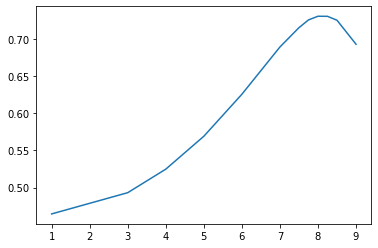

In [27]:
plt.plot(*zip(*sorted(list(scores.items()))))

In [28]:
sorted(list(scores.items()))

[(1, 0.4645626509612341),
 (3, 0.4931685046792633),
 (4, 0.5248488149750596),
 (5, 0.5691639528781764),
 (6, 0.6257118415770332),
 (7, 0.6893552138484118),
 (7.5, 0.7153463761143943),
 (7.75, 0.7257538812695593),
 (8, 0.7307334785826578),
 (8.25, 0.7306330110830538),
 (8.5, 0.7253245822738796),
 (9, 0.6930443535350583)]

In [32]:
THRESH = 8.1

In [ ]:
# cls on the val set

In [33]:
dists = [np.linalg.norm(xval - xval.iloc[i], axis = 1) for i in tqdm(range(len(xval)))]
dists = np.array(dists)

  0%|          | 0/10296 [00:00<?, ?it/s]

In [34]:
all_actuals = [actuals(yval,i) for i in tqdm(range(len(yval)))]
all_actuals = np.array(all_actuals)

  0%|          | 0/10296 [00:00<?, ?it/s]

In [35]:
score = get_score(dists, all_actuals, THRESH)
score

  0%|          | 0/10296 [00:00<?, ?it/s]

0.7570538685245904